# Mapas das médias das notas por disciplina e município para Neurodivergentes no Enem 2019

In [2]:

import numpy as np
import pandas as pd
import statistics  as sts
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import pearsonr
import folium
from folium import plugins
import json
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px

import warnings 
warnings.filterwarnings("ignore")



Fazer upload dos dados que contém as notas dos inscritos neurodivergentes no Enem em 2019 e do shape file do Brasil extraido do IBGE. 

In [3]:
dados = pd.read_csv('map_neurodiver_enem2019.csv')
dados.head()


,Unnamed: 0,Neurodivergente,Código_Geográfico,Município,UF,Cor_Raça,Gênero,Idade,Escolaridade_Pai,Escolaridade_Mãe,Computador.,Acesso_Internet,Redação,Ciências_Humanas,Ciências_Naturais,Matemática,Linguagens_Códigos,latitude,longitude
0,1,Deficit atenção,1501907,Bujaru,PA,Preta,M,18,H,H,Não,Sim,580,343.9,423.2,456.0,453.9,-1.633949,-48.088662
1,2,Autismo,1506807,Santarém,PA,Parda,F,17,C,E,Não,Não,580,510.3,490.4,544.8,548.2,-2.679336,-55.238455
2,3,Deficit atenção,1503804,Jacundá,PA,Amarela,M,17,E,E,Sim(1),Não,480,548.1,451.8,657.5,544.1,-4.598533,-49.181198
3,4,Deficiente mental,1501402,Belém,PA,Parda,F,24,B,C,Não,Não,560,392.2,423.0,386.6,402.8,-1.240719,-48.459911
4,5,Deficit atenção,5204904,Campos Belos,GO,Branca,F,29,B,E,Sim(1),Sim,460,546.9,449.2,469.8,518.9,-13.000299,-46.514392


In [4]:
# Selecionar colunas de interesse para as analises
dados2 = dados[['Município','UF','latitude','longitude','Ciências_Humanas', 'Ciências_Naturais', 'Redação', 'Matemática', 'Linguagens_Códigos', 'Neurodivergente']]

In [5]:
shape_path = '../ProjetoFinal/BRA_UF/BR_UF_2019.shp'


In [6]:
# Verificar shape file 
shape = gpd.read_file(shape_path)
print(shape.head())

  CD_UF     NM_UF SIGLA_UF NM_REGIAO  \
0    11  Rondônia       RO     Norte   
1    12      Acre       AC     Norte   
2    13  Amazonas       AM     Norte   
3    14   Roraima       RR     Norte   
4    15      Pará       PA     Norte   

                                            geometry  
0  POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...  
1  POLYGON ((-71.07772 -9.82774, -71.07817 -9.828...  
2  POLYGON ((-69.83766 -3.68659, -69.82555 -3.620...  
3  POLYGON ((-63.96008 2.47313, -63.96041 2.47416...  
4  MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ...  


Deletar colunas não desejadas

In [7]:

shape = shape.drop(columns=['CD_UF', 'NM_UF', 'NM_REGIAO'])


In [8]:
shape.head()

,SIGLA_UF,geometry
0,RO,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4..."
1,AC,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
2,AM,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
3,RR,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416..."
4,PA,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."


In [10]:
# Para fazer join dos datasets precisamos ter colunas em comum, aqui teremos a coluna UF em ambos os datasets. 
shape ['UF'] = shape ['SIGLA_UF']


In [11]:
shape2 = shape.drop(columns=['SIGLA_UF'])

### Verificar se os limites do país foram importados corretamente

<AxesSubplot:>

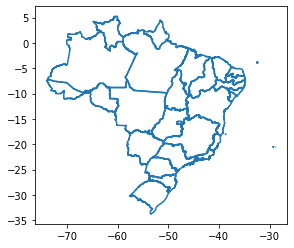

In [12]:

shape2.boundary.plot()

Fazer join dos datasets 

In [13]:

brasil = pd.merge(shape2, dados2, on='UF', how='left')

In [14]:
brasil.head()

,geometry,UF,Município,latitude,longitude,Ciências_Humanas,Ciências_Naturais,Redação,Matemática,Linguagens_Códigos,Neurodivergente
0,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,Porto Velho,-9.153405,-64.306699,506.6,452.0,300,472.6,521.7,Deficit atenção
1,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,Ariquemes,-9.951890,-62.957255,590.9,603.1,820,757.3,621.6,Deficit atenção
2,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,Porto Velho,-9.153405,-64.306699,396.8,366.2,0,367.8,477.8,Deficiente mental
3,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,Porto Velho,-9.153405,-64.306699,377.4,456.7,440,393.6,415.0,Autismo
4,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4...",RO,Cacoal,-11.301287,-61.324729,478.2,468.1,600,438.8,525.7,Deficiente mental


Calcular as médias das notas por disciplina e município

In [15]:

nota_media = dados2.groupby(['Município']).mean()[['Ciências_Humanas', 'Ciências_Naturais', 'Redação', 'Matemática', 'Linguagens_Códigos']]
nota_media['Municipio'] = nota_media.index
nota_media.head()

,Ciências_Humanas,Ciências_Naturais,Redação,Matemática,Linguagens_Códigos,Municipio
Município,,,,,,
Abaetetuba,494.21,506.77,618.0,499.54,506.04,Abaetetuba
Abaeté,404.60,427.30,420.0,427.45,430.05,Abaeté
Abatiá,668.40,634.40,960.0,747.60,651.10,Abatiá
Abre Campo,526.10,418.20,680.0,551.50,542.90,Abre Campo
Abreu e Lima,378.35,361.40,500.0,382.80,416.20,Abreu e Lima


Juntar os dois datasets para fazer os mapas

In [16]:

geo_notas = pd.merge(nota_media, brasil)
geo_notas = geo_notas.drop(columns=['Municipio'])
geo_notas.head()

,Ciências_Humanas,Ciências_Naturais,Redação,Matemática,Linguagens_Códigos,geometry,UF,Município,latitude,longitude,Neurodivergente
0,668.4,634.4,960.0,747.6,651.1,"MULTIPOLYGON (((-48.40736 -25.84270, -48.40750...",PR,Abatiá,-23.307151,-50.309609,Dislexia
1,526.1,418.2,680.0,551.5,542.9,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",MG,Abre Campo,-20.273172,-42.442634,Dislexia
2,464.0,521.9,660.0,600.2,532.7,"POLYGON ((-50.74208 -19.21384, -50.74241 -19.2...",MG,Acaiaca,-20.399832,-43.101202,Dislexia
3,516.7,378.5,540.0,470.9,481.7,"MULTIPOLYGON (((-40.75189 -20.92722, -40.75193...",ES,Afonso Cláudio,-20.088494,-41.127913,Deficiente mental
4,417.3,442.0,160.0,361.3,385.3,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017...",CE,Alcântaras,-3.592835,-40.544615,Deficiente mental


## Mapas

Mapas das médias para cada disciplina por município dos inscritos neurodivergentes no Enem em 2019.

Nessa análise consideramos neurodivergentes os inscritos que se declararam possuidor de: Autismo, Deficit atenção, Dislexia, Discalculia ou Deficiente mental. 

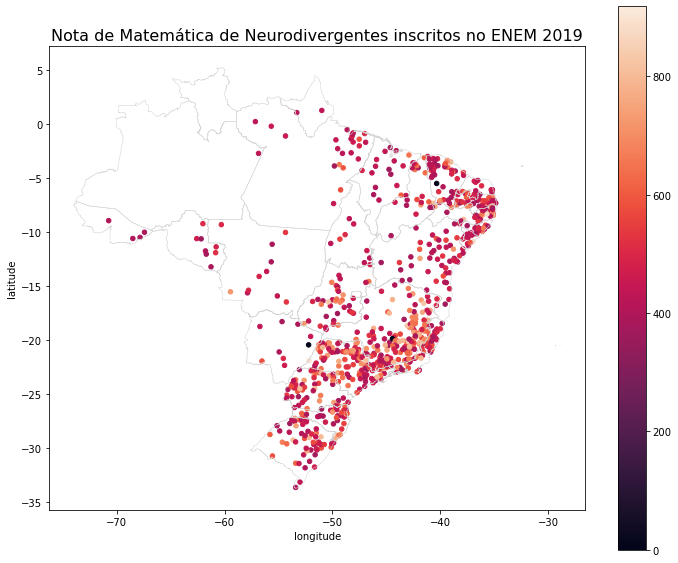

In [18]:
ax = shape2.boundary.plot(edgecolor='lightgray', linewidth=0.5, figsize=(12, 10))
geo_notas.plot.scatter(ax=ax, y='latitude', x = 'longitude', 
                         c = geo_notas['Matemática'],
                         cmap = "rocket",
                         figsize = (12,10)).set_title('Nota de Matemática de Neurodivergentes inscritos no ENEM 2019',  fontsize = 16);

Text(0.5, 1.0, 'Nota de Redação de Neurodivergentes no ENEM 2019')

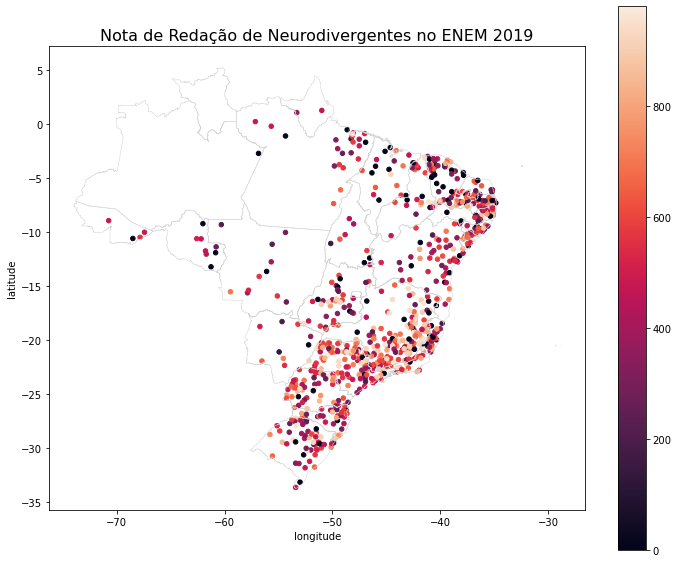

In [20]:
ax = shape2.boundary.plot(edgecolor='lightgray', linewidth=0.5, figsize=(12, 10))
geo_notas.plot.scatter(ax=ax, y='latitude', x = 'longitude', 
                         c = geo_notas['Redação'],
                         cmap = "rocket",
                         figsize = (12,10)).set_title('Nota de Redação de Neurodivergentes no ENEM 2019',  fontsize = 16)

Text(0.5, 1.0, 'Nota de Ciências Humanas de Neurodivergentes no ENEM 2019')

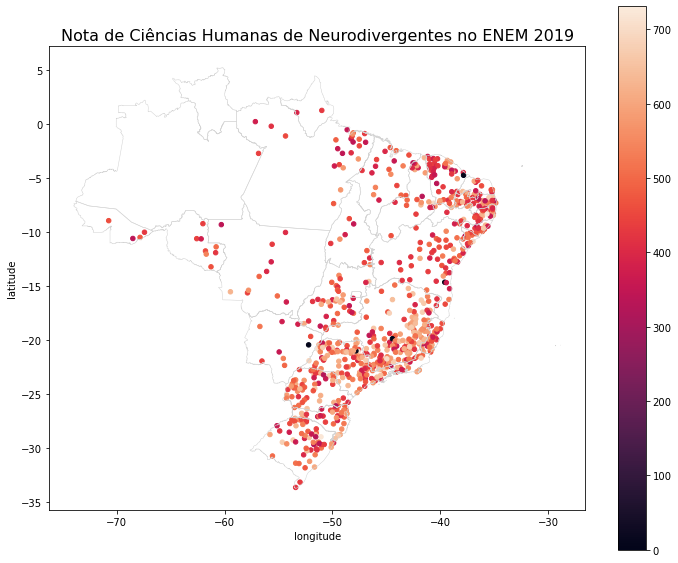

In [21]:
ax = shape2.boundary.plot(edgecolor='lightgray', linewidth=0.5, figsize=(12, 10))
geo_notas.plot.scatter(ax=ax, y='latitude', x = 'longitude', 
                         c = geo_notas['Ciências_Humanas'],
                         cmap = "rocket",
                         figsize = (12,10)).set_title('Nota de Ciências Humanas de Neurodivergentes no ENEM 2019',  fontsize = 16)

Text(0.5, 1.0, 'Nota de Ciências Naturais de Neurodivergentes no ENEM 2019')

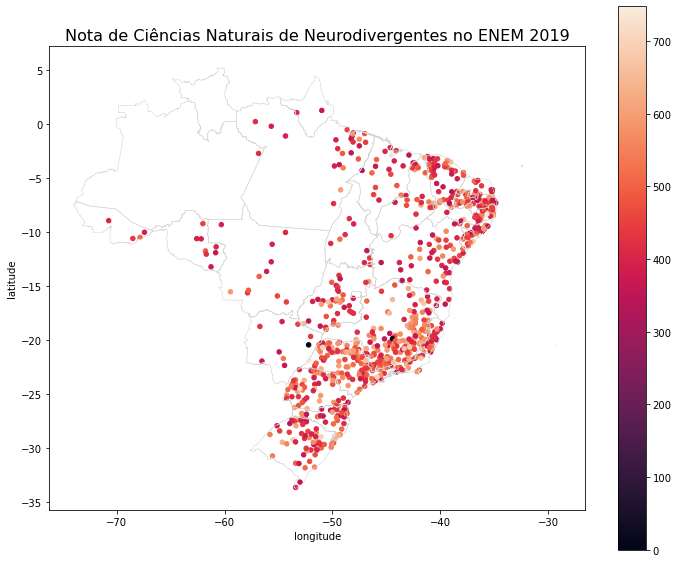

In [22]:
ax = shape2.boundary.plot(edgecolor='lightgray', linewidth=0.5, figsize=(12, 10))
geo_notas.plot.scatter(ax=ax, y='latitude', x = 'longitude', 
                         c = geo_notas['Ciências_Naturais'],
                         cmap = "rocket",
                         figsize = (12,10)).set_title('Nota de Ciências Naturais de Neurodivergentes no ENEM 2019',  fontsize = 16)

Text(0.5, 1.0, 'Nota de Linguagens e Códigos de Neurodivergentes no ENEM 2019')

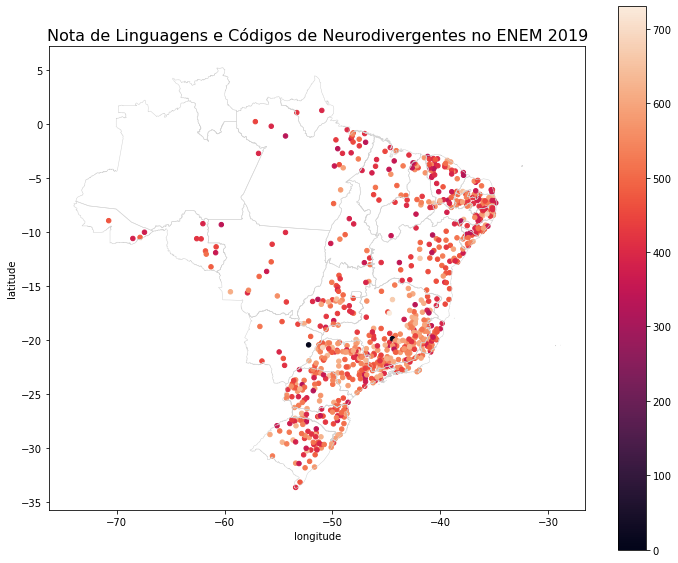

In [23]:
ax = shape2.boundary.plot(edgecolor='lightgray', linewidth=0.5, figsize=(12, 10))
geo_notas.plot.scatter(ax=ax,y='latitude', x = 'longitude', 
                         c = geo_notas['Linguagens_Códigos'],
                         cmap = "rocket",
                         figsize = (12,10)).set_title('Nota de Linguagens e Códigos de Neurodivergentes no ENEM 2019',  fontsize = 16)

Podemos observar que existe uma concentração das maiores notas para todas as disciplinas no Enem de 2019, na região Sudeste do Brasil, onde podemos constatar na análise descritiva que os inscritos declarados neurodivergentes provinham em maior número do estado de Minas Gerais, seguido do estados de São Paulo e Rio de Janeiro. 

É possivel que as condições sociais declaradas pelos inscritos neurodivergentes, como acesso a computadores e internet, assim como maior nivel de escolaridade entre os pais podem ter afetado positivamente o resultado nas provas desses inscritos, no entanto é necessário mais estudos incluindo aqueles que abandonaram a vida escolar por não ter acesso e condições adequadas as suas condições especiais, para verificar o impacto socio-economico em neurodivergentes em relação ao seus respectivos desempenho na vida escolar.

Aqui analisamos apenas as questões sociais que envolvem a família, não incluindo portanto variáveis que viriam a descrever o suporte ou não de organizações governamentais aos neurodivergentes, como melhorias e acesso as condições de ensino, assim como suporte psicopedagogico. De forma que, é necessario uma analise mais ampla sobre neurodivergentes e questões sociais no intuito de elaborar sugestões aos interessados, família, escolas e governos. 



# References

https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip

https://python-visualization.github.io/folium/modules.html

https://geopandas.org/en/stable/gallery/plotting_with_geoplot.html

https://github.com/ipeaGIT/geobr/blob/master/python-package/examples/1.%20intro-to-geobr.ipynb

https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/